<a href="https://colab.research.google.com/github/yeabwang/malaria-diagnosis/blob/main/Malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This model os a binary classification model which classifies cells as infected or not infected.
# Dataset to be used https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets
##### 27,558 cell images - from thin blood smear slides - contains both infected and uninfected cells.

In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [89]:
dataset,dataset_info = tfds.load('malaria',as_supervised=True,with_info=True, shuffle_files = True,split=['train'])

In [90]:
# Spliting our dataset into trianing, validation and testing

def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    train_dataset = dataset.take(int(train_ratio * dataset_size))  # Training set
    val_test_dataset = dataset.skip(int(train_ratio * dataset_size))  # Remaining
    val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))  # Validation set
    test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))  # Test set

    return train_dataset, val_dataset, test_dataset


In [91]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset,val_dataset,test_dataset = split_dataset(dataset[0],train_ratio,val_ratio,test_ratio)
# print(list(train_dataset.take(1).as_numpy_iterator())), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator())

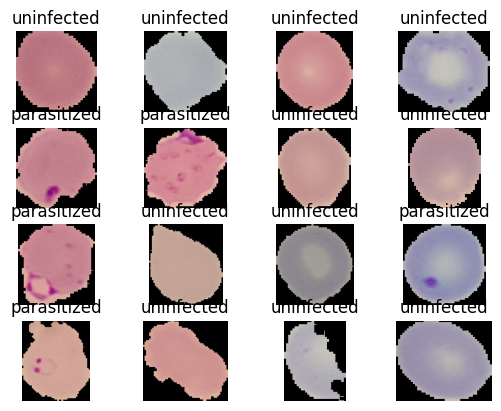

In [92]:
# Ploting some of the datas we have in our datset
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [93]:
# Resizing and Rescaling

image_size = 224

def resize_rescale(image, label):
    image = tf.image.resize(image, [image_size, image_size])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

train_dataset
val_dataset
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [94]:
#shuffling and taking a batch of our dataset

batch_size = 32

# For the training dataset
train_dataset = (
    train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# For the validation dataset
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# For the test dataset
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [95]:
# Building our model

channel_size = 3

model = Sequential([
    InputLayer(shape=(image_size, image_size, channel_size)),

    # First Convolutional Block
    Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Second Convolutional Block
    Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Third Convolutional Block (Optional)
    Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Dense Layer
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,185 (84.92 MB)

 Trainable params: 22,261,185 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# Defining our optimizer, loss function, measurement metrics and compiling our model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', 'AUC']
)

In [76]:
# # Calculating our loss
# # As one of the arguments in the Binary Cross Entrophy, if we are not sure that our output will be between 0 and one we have to use
# # from_logits = True to tell the model the prediction value might not be in the range of 0 and 1.

# y_true = np.array([0,])
# y_pred = np.array([0.8,])
# bce = BinaryCrossentropy(from_logits = False )

# loss = bce(y_true, y_pred)
# print("Binary Crossentropy Loss:", loss.numpy())


In [97]:
# Setting regularizations

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [98]:
# Training our model

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - AUC: 0.7423 - accuracy: 0.6748 - loss: 0.5994
Epoch 1: val_loss improved from inf to 0.20131, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 70s 93ms/step - AUC: 0.7425 - accuracy: 0.6750 - loss: 0.5992 - val_AUC: 0.9723 - val_accuracy: 0.9325 - val_loss: 0.2013 - learning_rate: 0.0010
Epoch 2/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - AUC: 0.9766 - accuracy: 0.9422 - loss: 0.1785
Epoch 2: val_loss improved from 0.20131 to 0.15133, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 87ms/step - AUC: 0.9766 - accuracy: 0.9422 - loss: 0.1785 - val_AUC: 0.9834 - val_accuracy: 0.9564 - val_loss: 0.1513 - learning_rate: 0.0010
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - AUC: 0.9843 - accuracy: 0.9555 - loss: 0.1397
Epoch 3: val_loss improved from 0.15133 to 0.14107, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 68s 97ms/step - AUC: 0.9843 - accuracy: 0.9555 - loss: 0.1397 - val

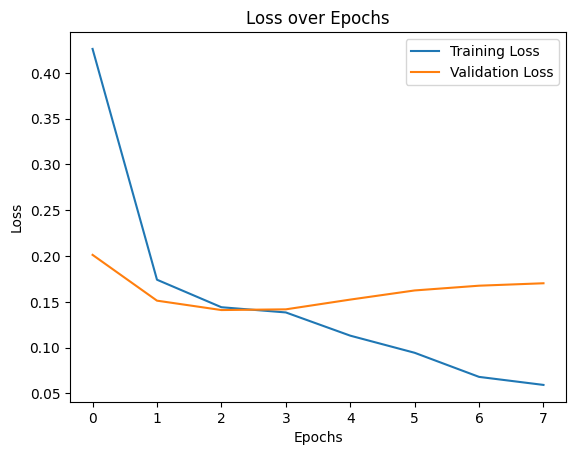

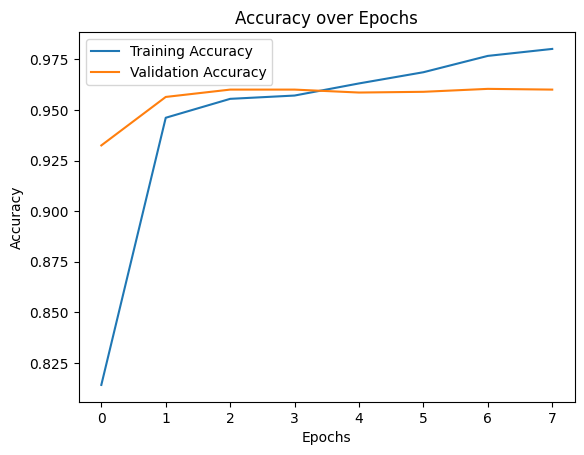

In [101]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [109]:
# Evaluate on the validation dataset
val_loss, val_accuracy, val_auc = model.evaluate(val_dataset, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Evaluate on the test dataset
test_loss, test_accuracy, test_auc = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 0.9887 - accuracy: 0.9609 - loss: 0.1265
Validation Loss: 0.1421
Validation Accuracy: 0.9593
Validation AUC: 0.9858
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 0.9826 - accuracy: 0.9540 - loss: 0.1607
Test Loss: 0.1531
Test Accuracy: 0.9532
Test AUC: 0.9839


In [110]:
model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


0.9723433

In [111]:
def labeler(x):
  if(x<0.5):
    return str('Postivie')
  else:
    return str('Negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


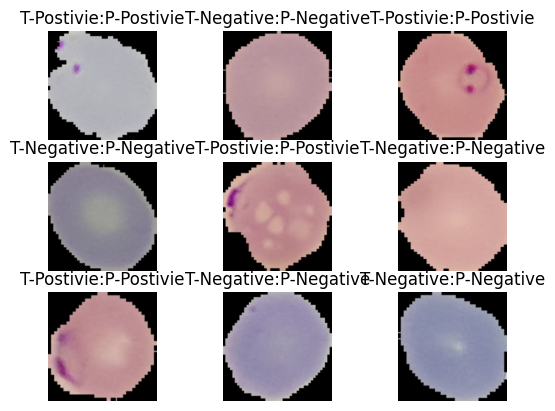

In [116]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str("T-"+labeler(label.numpy()[0])) + ":" + str("P-"+labeler(model.predict(image)[0][0])))

  plt.axis('off')